In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

100%|██████████| 62.6M/62.6M [00:04<00:00, 16.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/amer_sign3.png
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/amer_sign2.png
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/american_sign_language.PNG
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train/sign_mnist_train.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test/sign_mnist_test.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # Import tensorflow
#import keras # No need for separate keras import when using tensorflow.keras
from tensorflow.keras.models import Sequential # Update to tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization # Update to tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Update to tensorflow.keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau # Update to tensorflow.keras

In [6]:
train_df = pd.read_csv("/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train.csv")
test_df = pd.read_csv("/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test/sign_mnist_test.csv")

In [7]:
test = pd.read_csv("/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

<Axes: ylabel='count'>

Error in callback <function flush_figures at 0x7b53d3c59120> (for post_execute):


KeyboardInterrupt: 

In [10]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [12]:
x_train = train_df.values
x_test = test_df.values

In [13]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [14]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

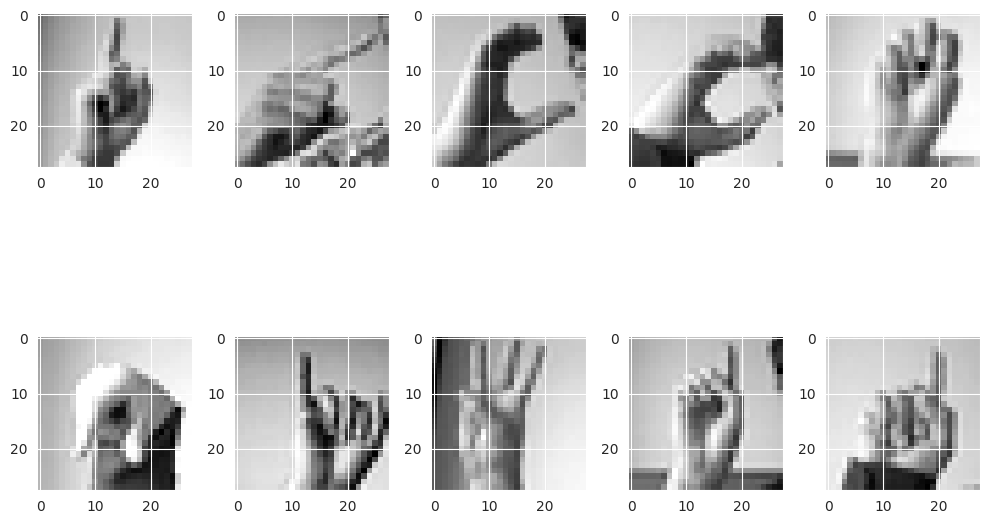

In [15]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [16]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [18]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 75)          │             750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 75)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          33,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 25)            │          11,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 25)            │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         205,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.4603 - loss: 1.8380 - val_accuracy: 0.0719 - val_loss: 4.0964 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9096 - loss: 0.2722 - val_accuracy: 0.5658 - val_loss: 1.5829 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9590 - loss: 0.1258 - val_accuracy: 0.9017 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9762 - loss: 0.0747 - val_accuracy: 0.9587 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9825 - loss: 0.0548 - val_accuracy: 0.9893 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9860 - loss: 0.0424 - val_accuracy: 0.9490 - val_loss: 0.1491 - learning_rate: 0.0010
Epoch 7/20
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9903 - loss: 0.0294


In [20]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9980 - loss: 0.0061
Accuracy of the model is -  99.8047947883606 %


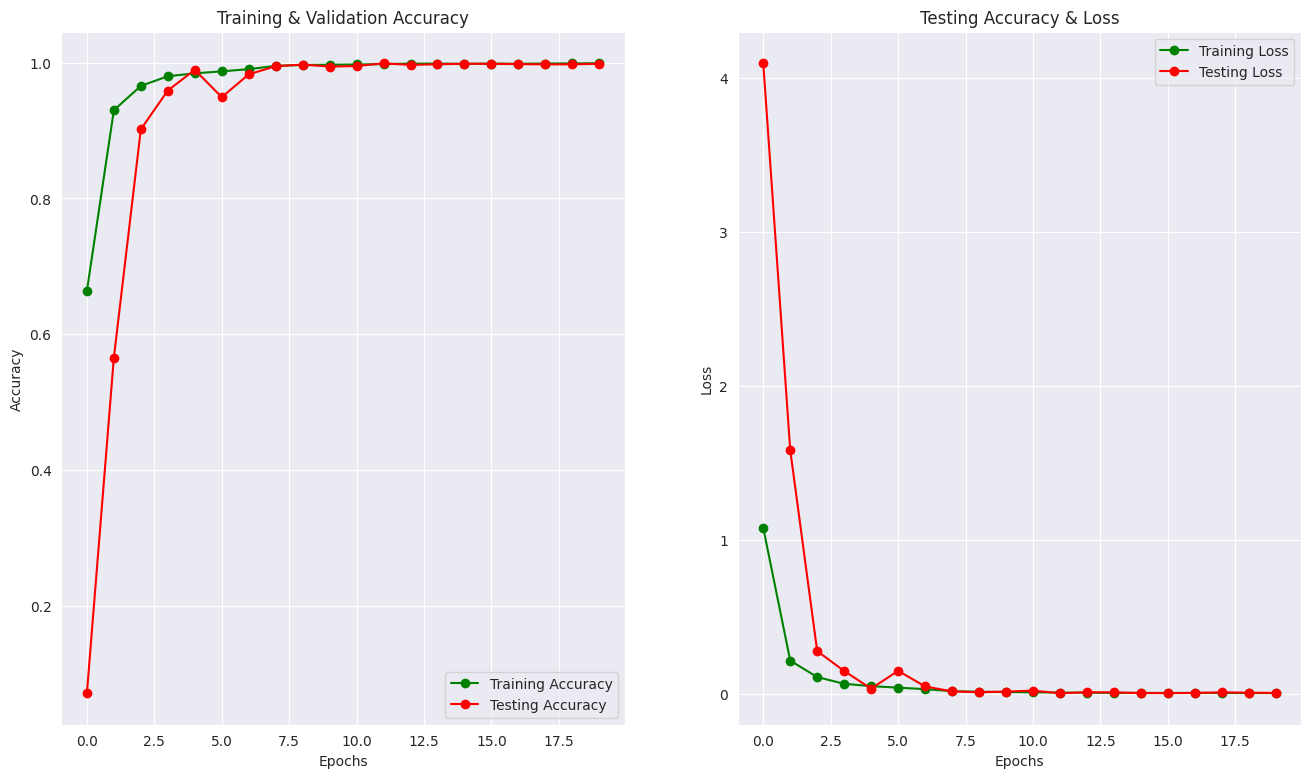

In [21]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [23]:
import numpy as np # Make sure numpy is imported

predictions = np.argmax(model.predict(x_test), axis=-1) # Use np.argmax to get predicted classes
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([ 6,  5, 10,  0,  3])

In [24]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      0.97      0.99       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       0.97      1.00      0.98       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [25]:
cm = confusion_matrix(y,predictions)

In [26]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<Axes: >

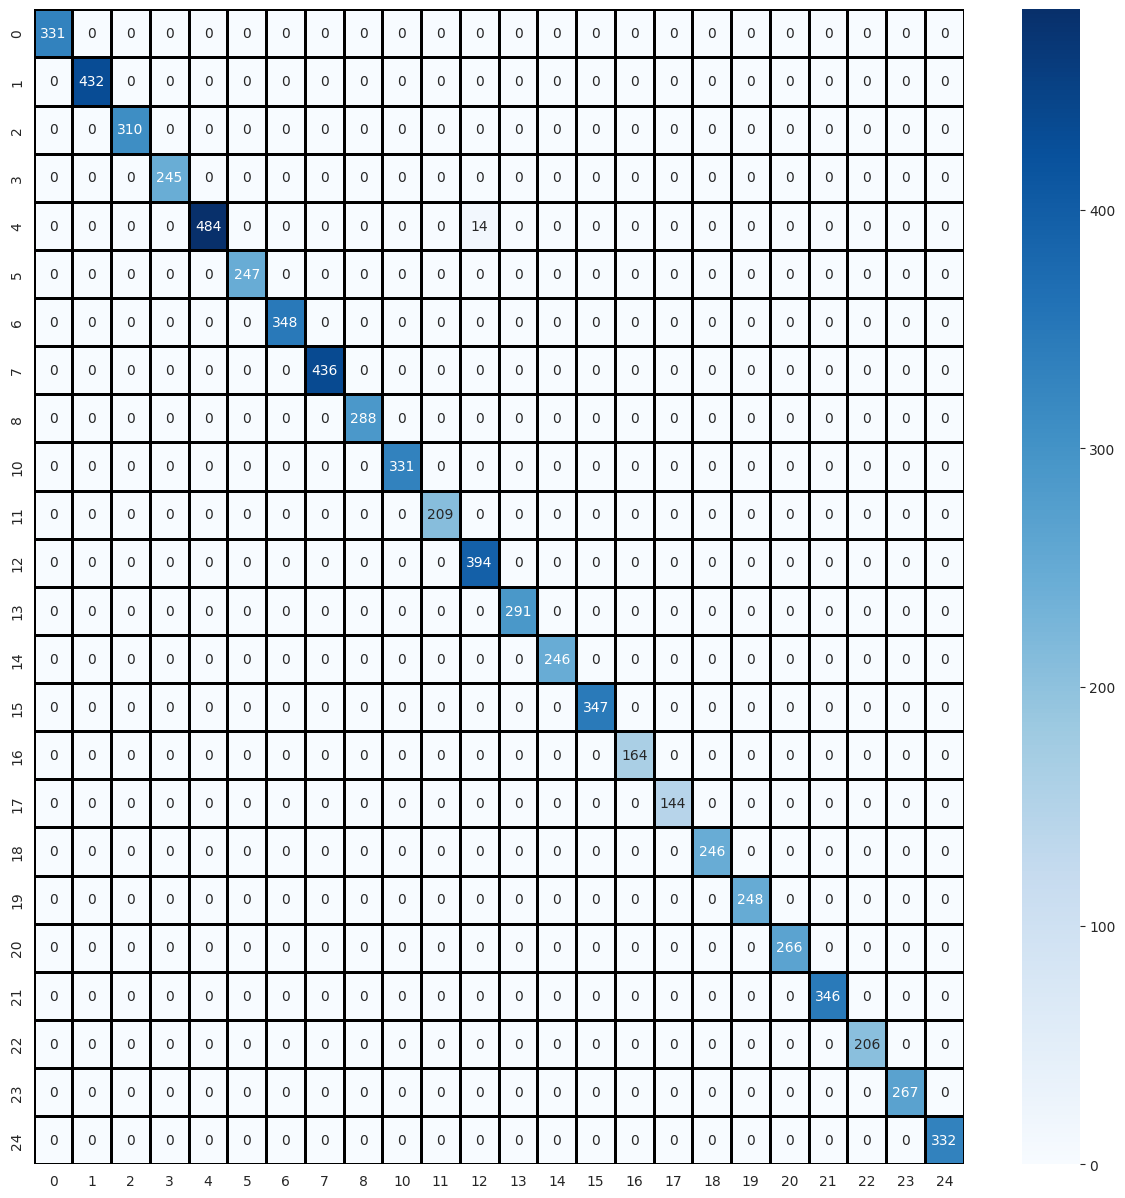

In [27]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [28]:
correct = np.nonzero(predictions == y)[0]

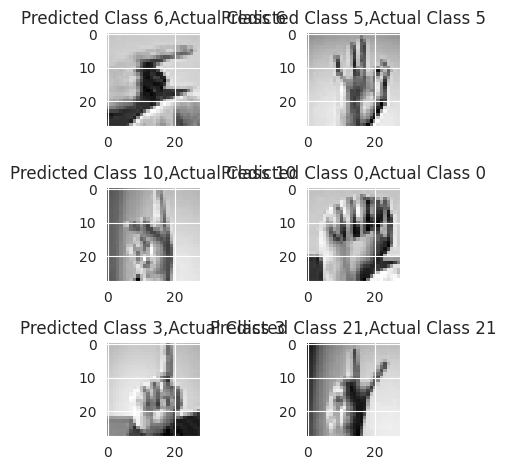

In [29]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [30]:
# Save the model after training
model.save('sign_language_recognition_model.h5')  # Save in HDF5 format
# model.save('sign_language_recognition_model')  # Uncomment to save in SavedModel format

In [34]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.5 MB/s eta 0:00:00


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from spellchecker import SpellChecker
import cv2  # For image preprocessing

# Load the saved model
model = load_model('/content/sign_language_recognition_model.h5')

# Define the class mapping (excluding index 9, as mentioned earlier)
class_mapping = [chr(i + 65) for i in range(26) if i != 9]

# Function to preprocess images
def preprocess_image(image_path):
    """
    Preprocess an input image for prediction.
    Assumes input is a grayscale image (28x28 pixels).
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    image = cv2.resize(image, (28, 28))  # Resize to 28x28
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.reshape(1, 28, 28, 1)  # Reshape for the model
    return image

# Function to predict a single letter
def predict_letter(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_mapping[predicted_class]

# Example: List of image paths (replace these with actual paths)
image_paths = ["/content/E.jpeg"]

# Predict letters for the series of images
predicted_letters = [predict_letter(image_path) for image_path in image_paths]
print("Predicted Letters:", predicted_letters)

# Combine letters to form a word
predicted_word = ''.join(predicted_letters)
print("Predicted Word:", predicted_word)

# Use a spellchecker to correct the word
spell = SpellChecker()
corrected_word = spell.correction(predicted_word)
print("Corrected Word:", corrected_word)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted Letters: ['S']
Predicted Word: S
Corrected Word: S
